<a href="https://colab.research.google.com/github/buswayne/stock_prediction_LSTM_technical_indicators/blob/master/Stock_Price_Prediction_Technical_Indicators.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Notebook for stock price prediction using Technical Indicators

Import libraries

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

Notebook intended to be run in Google Colab --> use TensorFlow GPU for faster computing.

If you intend to run the code in your PC, use the tf version that fits your requirements

In [ ]:

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Dense
print(tf.__version__)
print(tf.test.gpu_device_name())

2.11.0
/device:GPU:0


Install and import ta library, library to compute techincal indicators from a dataset

In [ ]:
! pip install --upgrade ta
import ta

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
  Created wheel for ta: filename=ta-0.10.2-py3-none-any.whl size=29103 sha256=9e181d97ac5ab9af003c73ffce1c899761c06c8e3ed775b25c64741cfa32d43e
  Stored in directory: /root/.cache/pip/wheels/6a/76/03/7f785aaa50b9c6ec7e3fd105a62c1b2c45a034512d51e024a9
Successfully built ta


Mount your drive to access the CSV file directly from path

In [ ]:
# %%capture
# from google.colab import drive
# drive.mount('/content/drive')

Alternatevely, use the colab function and directly load the csv file

In [ ]:
# from google.colab import files
# csv_file = files.upload()

## Prepare Dataset

In [ ]:
csv_file = '/content/NVDA.csv'
dataset = pd.read_csv(csv_file, index_col='Date')
dataset.index = pd.to_datetime(dataset.index).strftime('%Y-%m-%d')
dataset = ta.utils.dropna(dataset)
print(dataset.shape)
dataset.tail()

(1259, 6)


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2020-04-08,263.410004,267.950012,260.600006,266.950012,266.950012,13561100
2020-04-09,272.000000,272.920013,260.420013,262.950012,262.950012,13156200
2020-04-13,260.549988,270.200012,257.000000,269.850006,269.850006,9960200
2020-04-14,275.000000,285.320007,273.890015,283.950012,283.950012,13273700
2020-04-15,277.200012,284.170013,275.380005,280.839996,280.839996,9128400


Add Techical Indicators to the Dataset

In [ ]:
dataset = ta.add_all_ta_features(dataset, open="Open", high="High", low="Low", close="Close", volume="Volume")

/usr/local/lib/python3.9/dist-packages/ta/trend.py:780: RuntimeWarning: invalid value encountered in double_scalars
  dip[idx] = 100 * (self._dip[idx] / value)
/usr/local/lib/python3.9/dist-packages/ta/trend.py:785: RuntimeWarning: invalid value encountered in double_scalars
  din[idx] = 100 * (self._din[idx] / value)


Display the dataset and check how it looks like.
Final # of columns should be 78

In [ ]:
print(dataset.shape)
display(dataset.head())

(1259, 92)


,Open,High,Low,Close,Adj Close,Volume,volume_adi,volume_obv,volume_cmf,volume_fi,...,momentum_ppo,momentum_ppo_signal,momentum_ppo_hist,momentum_pvo,momentum_pvo_signal,momentum_pvo_hist,momentum_kama,others_dr,others_dlr,others_cr
Date,,,,,,,,,,,,,,,,,,,,,
2015-04-16,22.500000,22.690001,22.330000,22.490000,21.752443,3882100,-4.313540e+05,3882100,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-83.931016,NaN,0.000000
2015-04-17,22.020000,22.420000,22.010000,22.200001,21.471954,7340900,-9.684572e+05,-3458800,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1.289458,-1.297843,-1.289458
2015-04-20,22.299999,22.440001,22.049999,22.090000,21.365564,5790600,-5.571218e+06,-9249400,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.495500,-0.496732,-1.778568
2015-04-21,22.360001,22.360001,21.950001,22.059999,21.336546,5761400,-8.241192e+06,-15010800,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.135813,-0.135905,-1.911965
2015-04-22,22.190001,22.340000,21.850000,22.309999,21.578348,5185500,-3.690672e+06,-9825300,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.133273,1.126900,-0.800360


From all the techical indicators created, select the most relevant. Custom decisions can be made, you are welcome to try different indicators and different combinations.

In [ ]:
data = dataset[['Open',
                'High',
                'Low',
                'Close',
                #'volatility_bbm',#'volatility_bbh','volatility_bbl',
                #'trend_ichimoku_a','trend_ichimoku_b',
                'momentum_rsi',
                'trend_macd_diff',
                #'trend_psar',
                #'momentum_stoch','momentum_stoch_signal',
                #'trend_adx'
                ]]

Drop rows with NaN values. NaN values are related to computation of Moving Averages that require a minimum number of days in the period. Removing NaN values does not affect the performances since only a minimum part of the head of the dataset is removed.

In [ ]:
data = data.dropna()
data.head()

,Open,High,Low,Close,momentum_rsi,trend_macd_diff
Date,,,,,,
2015-06-03,22.000000,22.170000,21.660000,21.700001,49.897055,0.140265
2015-06-04,21.570000,22.160000,21.570000,22.090000,55.237023,0.139022
2015-06-05,22.020000,22.360001,21.790001,22.260000,57.369881,0.142905
2015-06-08,22.190001,22.340000,21.500000,21.750000,49.716558,0.106074
2015-06-09,21.770000,22.020000,21.730000,21.860001,51.227852,0.084982


Scale the data with MinMaxScaler

N.B. Define two different scalers: sc for scaling the dataset, sc_Y to be used later to rescale output

In [ ]:
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler()
sc_Y = MinMaxScaler()
scaled_data = sc.fit_transform(data)
sc_Y.fit(data['Close'].values.reshape(-1,1))

MinMaxScaler()

Re-define created sets as DataFrame

In [ ]:
scaled_data = pd.DataFrame(scaled_data, columns=data.columns, index=data.index)
scaled_data.head()

,Open,High,Low,Close,momentum_rsi,trend_macd_diff
Date,,,,,,
2015-06-03,0.009369,0.008895,0.009101,0.008091,0.460113,0.593732
2015-06-04,0.007904,0.008861,0.008782,0.009411,0.539198,0.593643
2015-06-05,0.009437,0.009535,0.009561,0.009987,0.570786,0.593922
2015-06-08,0.010016,0.009468,0.008534,0.008260,0.457439,0.591277
2015-06-09,0.008585,0.008390,0.009348,0.008633,0.479822,0.589763


## Split data_X in Train and Test set

**Idea of the algorithm:** use the last **N_past** days to predict the **M_future** days.\
In general, increasing N_past increases the accuracy of the model.
Viceversa, incresing M_future decreases the accuracy of the model.

Notice however that a too high value of N_past not only increases the complexity of the model, but also can lead to worse result if the market is in a high volatility period.\
\
Also in this case, try different combinations.

In [ ]:
N_past = 7
M_future = 3

In [ ]:
test_percentage = 0.15
test_split = int(len(scaled_data)*(1 - test_percentage))

In [ ]:
train = scaled_data[:test_split]
test = scaled_data[test_split-N_past:]
print(train.shape)
print(test.shape)

(1042, 6)
(191, 6)


Create a function to prepare X and y sets to be used in the regression.

X will be an array with length = len(train). Each element i of the array will have shape (N_past, number_of_regressors), representing the N_past days x the selected technical features for that day.

Y will be an array with length = len(train). Each element i of the array will have shape (M_future, 1), representing the M_future days Close prices.

Example: N_past = 10, M_future = 5.
The 15th element of X will contain (15th,16th,17th,..24th) day, and each day is described by selected features.
The 15th element of Y will contain (25th,26th,27th) day Closing price.

The function iterates from day 0 to day (len(data) - past - future)  because we need N_past days to make the prediction and N_future days to assign the Y value.
Jump is a variable used to skip values in order to avoid superimposition between predicted values. During training and testing it is = 1 because we exploit each (X,y) couple to train/test.

In [ ]:
def split_dataset_X_Y(data, past, future, jump=1):
  X,Y = [],[]
  for i in range(0, len(data) - past - future + 1, jump):
    X.append(data[i : (i+past)].values)
    Y.append(data['Close'][(i + past) : (i + past + future)])
  return np.array(X), np.array(Y)

In [ ]:
X_train, y_train = split_dataset_X_Y(train, N_past, M_future)
X_test, y_test = split_dataset_X_Y(test, N_past, M_future)

Split train into train and validation sets

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_validation, y_train, y_validation = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

In [ ]:
print(X_train.shape)
print(y_train.shape)
print(X_validation.shape)
print(y_validation.shape)
print(X_test.shape)
print(y_test.shape)

(826, 7, 6)
(826, 3)
(207, 7, 6)
(207, 3)
(182, 7, 6)
(182, 3)


## LSTM Model

In [ ]:
EPOCHS = 100

In [ ]:
model = Sequential()
model.add(LSTM(8, input_shape=(N_past, data.shape[1]), return_sequences=True))
# model.add(Dropout(0.2))
# model.add(LSTM(64, return_sequences=True))
# model.add(Dropout(0.2))
model.add(LSTM(8))
# model.add(Dropout(0.2))
model.add(Dense(M_future))
model.compile(loss='mean_squared_error', optimizer='rmsprop')
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 7, 8)              480       
                                                                 
 lstm_1 (LSTM)               (None, 8)                 544       
                                                                 
 dense (Dense)               (None, 3)                 27        
                                                                 
Total params: 1,051
Trainable params: 1,051
Non-trainable params: 0
_________________________________________________________________


In [ ]:
history = model.fit(X_train, y_train, epochs=EPOCHS, validation_data=(X_validation, y_validation), shuffle=True, batch_size=8, verbose=2)

Epoch 1/100
104/104 - 9s - loss: 0.0318 - val_loss: 0.0057 - 9s/epoch - 89ms/step
Epoch 2/100
104/104 - 1s - loss: 0.0026 - val_loss: 0.0019 - 537ms/epoch - 5ms/step
Epoch 3/100
104/104 - 1s - loss: 0.0014 - val_loss: 0.0015 - 559ms/epoch - 5ms/step
Epoch 4/100
104/104 - 1s - loss: 0.0012 - val_loss: 0.0012 - 542ms/epoch - 5ms/step
Epoch 5/100
104/104 - 1s - loss: 0.0011 - val_loss: 0.0013 - 556ms/epoch - 5ms/step
Epoch 6/100
104/104 - 1s - loss: 0.0011 - val_loss: 0.0015 - 624ms/epoch - 6ms/step
Epoch 7/100
104/104 - 1s - loss: 0.0010 - val_loss: 0.0011 - 535ms/epoch - 5ms/step
Epoch 8/100
104/104 - 1s - loss: 9.4690e-04 - val_loss: 0.0013 - 650ms/epoch - 6ms/step
Epoch 9/100
104/104 - 1s - loss: 9.3332e-04 - val_loss: 0.0010 - 535ms/epoch - 5ms/step
Epoch 10/100
104/104 - 1s - loss: 9.1129e-04 - val_loss: 9.5581e-04 - 765ms/epoch - 7ms/step
Epoch 11/100
104/104 - 1s - loss: 9.1323e-04 - val_loss: 9.1160e-04 - 838ms/epoch - 8ms/step
Epoch 12/100
104/104 - 1s - loss: 9.0308e-04 - val_l

### Plot Loss vs Validation Loss

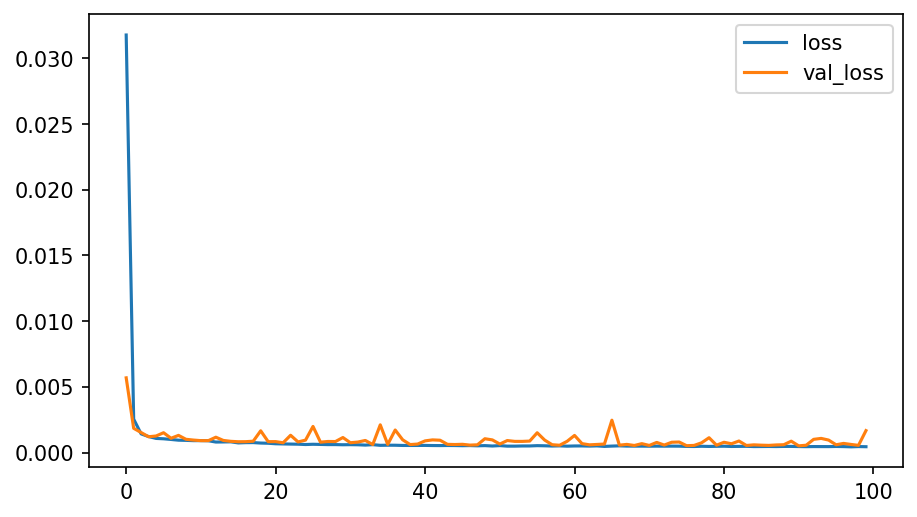

In [ ]:
plt.figure(figsize = (7,4), dpi=150)
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend(loc='best')
plt.show()

## Predict over the test set

In [ ]:
y_pred = model.predict(X_test)

6/6 [==============================] - 1s 3ms/step


Create a DataFrame with y_test and y_pred. Since element of y_test[i,1] is equal to element of y_test[i+1,0], let's take only y_test[:,0], which are the Close prices of the **first day** of the predictions i.

In [ ]:
df = pd.DataFrame({'y_test': sc_Y.inverse_transform(y_test[:,0].reshape(-1,1)).flatten(),
                   'y_pred': sc_Y.inverse_transform(y_pred[:,0].reshape(-1,1)).flatten()},
                   test[N_past:N_past+len(y_test)].index)

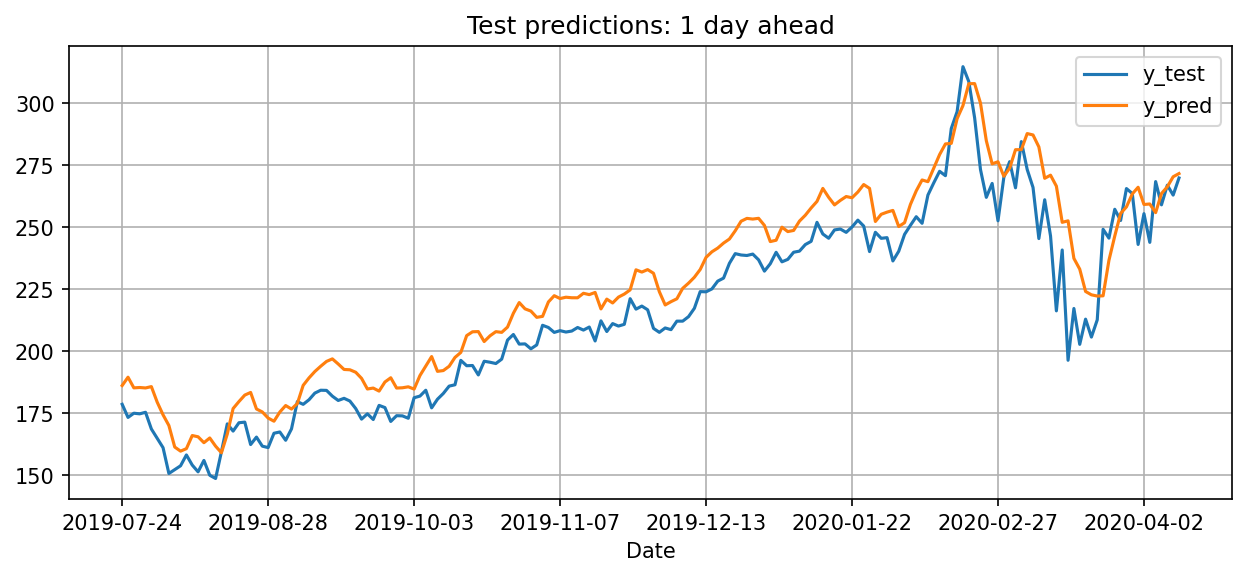

In [ ]:
fig = plt.figure(figsize=(10,4), dpi=150)
df['y_test'].plot()
df['y_pred'].plot()
plt.legend(loc='best')
plt.title('Test predictions: 1 day ahead')
plt.grid(True)
plt.show()

Notice that the further in time we try to predict the Close price, the worse the predictions are (it makes sense). Compare the previous plot with the following, where last Close prices in the prediction window are taken into consideration.

In [ ]:
df_2 = pd.DataFrame({'y_test': sc_Y.inverse_transform(y_test[:,-1].reshape(-1,1)).flatten(),
                   'y_pred': sc_Y.inverse_transform(y_pred[:,-1].reshape(-1,1)).flatten()},
                   test[N_past+M_future-1:].index)

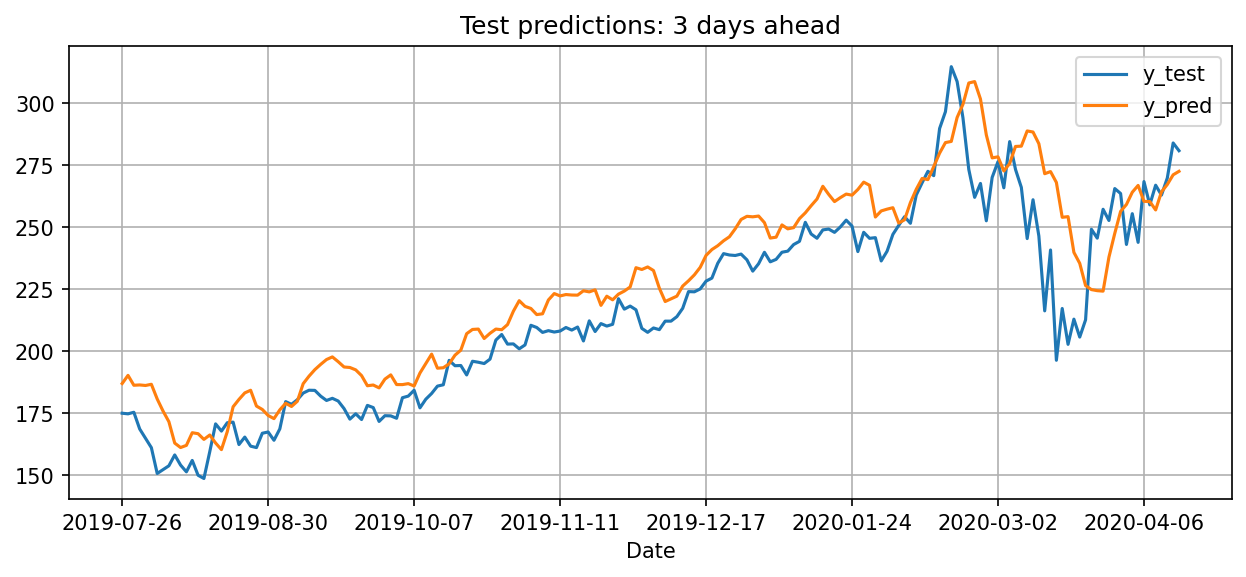

In [ ]:
fig = plt.figure(figsize=(10,4), dpi=150)
df_2['y_test'].plot()
df_2['y_pred'].plot()
plt.legend(loc='best')
plt.title('Test predictions: %i days ahead'%M_future)
plt.grid(True)
plt.show()

## Prediction of the overall dataset

Conceptually repeat the step above, this time jumping in time by M_future days each time

Since the algorithm requires N_past days, the Train-Test split must be adjusted to predict all the Time Series

In [ ]:
train = scaled_data[(test_split-M_future-N_past) % M_future : test_split]
test = scaled_data[test_split - N_past:]
print(train.shape)
print(test.shape)

(1042, 6)
(191, 6)


In [ ]:
X_train, y_train = split_dataset_X_Y(train, N_past, M_future, M_future)
X_test, y_test = split_dataset_X_Y(test, N_past, M_future, M_future)

Check that last day in y_train is the day before the first day in y_test.

In [ ]:
print('Last Close price for y_train is %.6f'%(y_train[-1][-1]))
print('First Close price for y_test is %.6f'%(y_test[0][0]))
display(test.iloc[N_past-1:N_past+1])

Last Close price for y_train is 0.529300
First Close price for y_test is 0.539456


,Open,High,Low,Close,momentum_rsi,trend_macd_diff
Date,,,,,,
2019-07-23,0.523474,0.526332,0.542422,0.529300,0.760018,0.655496
2019-07-24,0.538805,0.536945,0.549752,0.539456,0.798507,0.672039


Make predictions over the Train set

In [ ]:
train_predictions = model.predict(X_train).ravel()

11/11 [==============================] - 0s 3ms/step


Make predictions over the Test set

In [ ]:
test_predictions = model.predict(X_test).ravel()

2/2 [==============================] - 0s 6ms/step


Combine y_train and y_test in an unique vector y_true, target values

In [ ]:
y_true = np.concatenate((y_train.ravel(), y_test.ravel()), axis=0)

Adjust train_predictions and test_predictions with NaN values so that they have the same length and can be plotted together

In [ ]:
for _ in range(len(y_true)-len(train_predictions)):
  train_predictions = np.append(train_predictions, np.nan)

for _ in range(len(y_true)-len(test_predictions)):
  test_predictions = np.insert(test_predictions, 0, np.nan, axis=0)

In [ ]:
assert (y_true.shape == train_predictions.shape == test_predictions.shape)

Create a Final DataFrame with the true values and the predicted values

In [ ]:
lb = (test_split-M_future-N_past) % M_future + N_past
ub = lb + len(y_true)

In [ ]:
complete_df = pd.DataFrame({'y_true': sc_Y.inverse_transform(y_true.reshape(-1,1)).flatten(),
                            'train_predictions': sc_Y.inverse_transform(train_predictions.reshape(-1,1)).flatten(),
                            'test_predictions': sc_Y.inverse_transform(test_predictions.reshape(-1,1)).flatten()},
                           data[lb:ub].index)

Static Plot

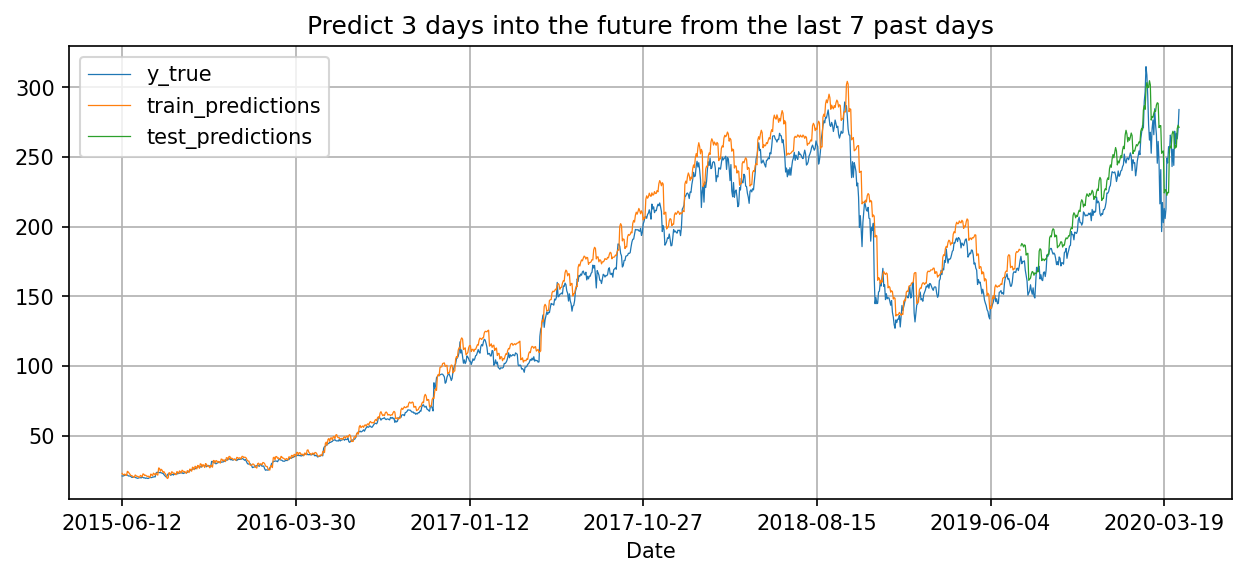

In [ ]:
fig = plt.figure(figsize=(10,4), dpi=150)
complete_df['y_true'].plot(linewidth=0.6)
complete_df['train_predictions'].plot(linewidth=0.6)
complete_df['test_predictions'].plot(linewidth=0.6)
plt.legend(loc='best')
plt.title('Predict %i days into the future from the last %i past days'%(M_future,N_past))
plt.grid(True)
plt.show()

Interactive Plot

In [ ]:
import plotly.graph_objects as go
fig = go.Figure()
fig.add_trace(go.Scatter(x=complete_df.index,
                         y=complete_df['y_true'],
                         name='True',
                         mode='lines',
                         line = dict(color='steelblue',
                                     width=2)))
fig.add_trace(go.Scatter(x=complete_df.index,
                         y=complete_df['train_predictions'],
                         name='Predicted over Train',
                         mode='lines',
                         line = dict(color='darkorange',
                                     width=2)))
fig.add_trace(go.Scatter(x=complete_df.index,
                         y=complete_df['test_predictions'],
                         name='Predicted over Test',
                         mode='lines',
                         line = dict(color='green',
                                     width=2)))
fig.update_layout(
    xaxis=dict(
        showline=True,
        showgrid=True,
        gridcolor='rgb(204, 204, 204)',
        showticklabels=True,
        linecolor='black',
        linewidth=1,
        ticks='outside',
        tickfont=dict(
            family='Arial',
            size=12,
            color='rgb(82, 82, 82)',
        )),
    yaxis=dict(
        showgrid=True,
        gridcolor='rgb(204, 204, 204)',
        linewidth=0.3,
        linecolor='black',
        zeroline=True,
        showline=True,
        showticklabels=True,
    ),
    title={
    'text': 'Predict %i days into the future from the last %i past days'%(M_future,N_past),
    'y':0.9,
    'x':0.5,
    'xanchor': 'center',
    'yanchor': 'top'},
    yaxis_title='Price',
    xaxis_title='Date',
    autosize=False,
    width=1440,
    height=608,
    plot_bgcolor='white')

fig.show()

## Predict Future Values!!

To make an actual prediction, select the very last available N days and reshape them so that the sample can be fed into our model (expected 3D)

In [ ]:
last_days = scaled_data[-N_past:].values.reshape(1, N_past, -1)

In [ ]:
prediction = model.predict(last_days)
prediction = sc_Y.inverse_transform(prediction).flatten()

1/1 [==============================] - 0s 25ms/step


Here the predicted prices for the next days!!

In [ ]:
data[-1:]

,Open,High,Low,Close,momentum_rsi,trend_macd_diff
Date,,,,,,
2020-04-15,277.200012,284.170013,275.380005,280.839996,57.882237,4.219138


In [ ]:
print('Predicted prices for the future %i days are:'%M_future)
for price in prediction:
  print(price)

Predicted prices for the future 3 days are:
284.12332
286.57086
284.67783
